In [53]:
import numpy as np
import pandas as pd
%matplotlib inline
from visualization import *
from util_tsne_exact import *
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
mpl.rcParams['figure.figsize'] = (8.1, 5)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.family'] = 'Roboto'
mpl.rcParams['font.size'] = 15

## Calculating FLOPs per part

In [22]:
D = 28*28
d = 2
T = 1000

def get_flops(iters, implementation):
    assert implementation in ("baseline", "scalar", "avx")
    # Compute the flops for baseline
    N = iters["N"]
    it = iters["iters"]
    
    if implementation == "baseline":
        flops_distance_baseline = 3*N*D + D + (1.5)*D*N*(N-1)
        flops_perplexity_baseline = it * (2 * N + N + 3 * N + 7) + N**2
        flops_symmetrize_baseline = N * (N-1) / 2 + 3 * N**2
        flops_ld_affinities_baseline = T * (7 * N * (N - 1) + 3 * N**2)
        flops_gradient_baseline = T * (9 * N * (N - 1) + 4*N + 2 + 2*N)
        flops_total_baseline = flops_distance_baseline + flops_perplexity_baseline + \
            flops_symmetrize_baseline + flops_ld_affinities_baseline + flops_gradient_baseline
        flops = np.vstack([flops_distance_baseline, flops_perplexity_baseline, 
                                flops_symmetrize_baseline, flops_ld_affinities_baseline,
                               flops_gradient_baseline, flops_total_baseline]).T

    if implementation == "scalar":
        flops_distance_scalar = 3*N*D+ D + 2*N*D + (1.5)*D*N*(N-1)
        flops_perplexity_scalar = it * (2 * N + N + 3 * N + 7) + N**2
        flops_symmetrize_scalar = N * (N-1) / 2 + 3 * N**2
        flops_ld_affinities_scalar = T * (10/2 * N * (N - 1))
        flops_gradient_scalar = T * (9 * N**2 + 4*N + 2 + 2*N)
        flops_total_scalar = flops_distance_scalar + flops_perplexity_scalar + flops_perplexity_scalar + \
            flops_ld_affinities_scalar + flops_gradient_scalar
        flops = np.vstack([flops_distance_scalar, flops_perplexity_scalar,
                            flops_symmetrize_scalar, flops_ld_affinities_scalar,
                            flops_gradient_scalar, flops_total_scalar]).T
    if implementation == "avx":
        flops_distance_avx = (D//8) * ( (N//8) * 64 + (N%8) * 8 + 7*8 + N*8 ) + \
                (d%8) * (8 * (N//8) + (N%8) + 7 +N ) + D + 2 +  1 + \
                (N//8) * (112*D + 448 + ( (N//8) -1) * (64*D + 256) + (N%8)*(2*D + 8) ) + \
                (N//8) * (56*D + 56 + ( (N//8) -1) * (32*D + 4) + (N%8)*(1*D + 1) )
        flops_perplexity_avx = it * (2 * N + N + 3 * N + 7) + N**2
        flops_symmetrize_avx = N * (N-1) / 2 + 3 * N**2
        flops_ld_affinities_avx = T * (N/8*(N/8-1)/2 * (16*8 + 8*8 + 8*8*2 + 8*8 + 8*8 + 8*8))
        flops_gradient_avx = T * (N/16*(N/8*(16*8 + 4*8*8 + 4*4*8 + 4*4*8 + 4*16*8) + (4*8 + 4*16)) + \
                N/(4*8) * (8*8) + 11*8 + N/(4*8)*(8*8))
        flops_total_avx = flops_distance_avx + flops_perplexity_avx + flops_symmetrize_avx + \
            flops_ld_affinities_avx + flops_gradient_avx
        flops = np.vstack([flops_distance_avx, flops_perplexity_avx,
                                 flops_symmetrize_avx, flops_ld_affinities_avx,
                                 flops_gradient_avx, flops_total_avx]).T
    return flops

### Compare compiler

In [75]:
results_dir = "../code/implementations/tsne_exact_final/toaster_bench/"

def load_run(name):
    implementation = name.split("_")[0]
    iters = pd.read_csv(os.path.join(results_dir, f"{name}_count.csv"))
    cycles = pd.read_csv(os.path.join(results_dir, f"{name}_cycles.csv"))
    flops = get_flops(iters, implementation)
    N = cycles.as_matrix()[:,0]
    cycles_ = cycles.as_matrix()[:,1:]
    perf = flops/cycles_
    return {
        "N": N, 
        "cycles": cycles_, 
        "flops": flops, 
        "perf": perf
    }

baseline_gcc_novec = load_run("baseline_gcc_novec")
baseline_icc_novec = load_run("baseline_icc_novec")
baseline_gcc_vec = load_run("baseline_gcc_vec")
baseline_icc_vec = load_run("baseline_icc_vec")
N = baseline_gcc_novec["N"]
scalar_gcc_novec = load_run("scalar_gcc_novec")
scalar_icc_novec = load_run("scalar_icc_novec")
scalar_gcc_vec = load_run("scalar_gcc_vec")
scalar_icc_vec = load_run("scalar_icc_vec")
avx_gcc_vec = load_run("avx_gcc_vec")
avx_icc_vec = load_run("avx_icc_vec")

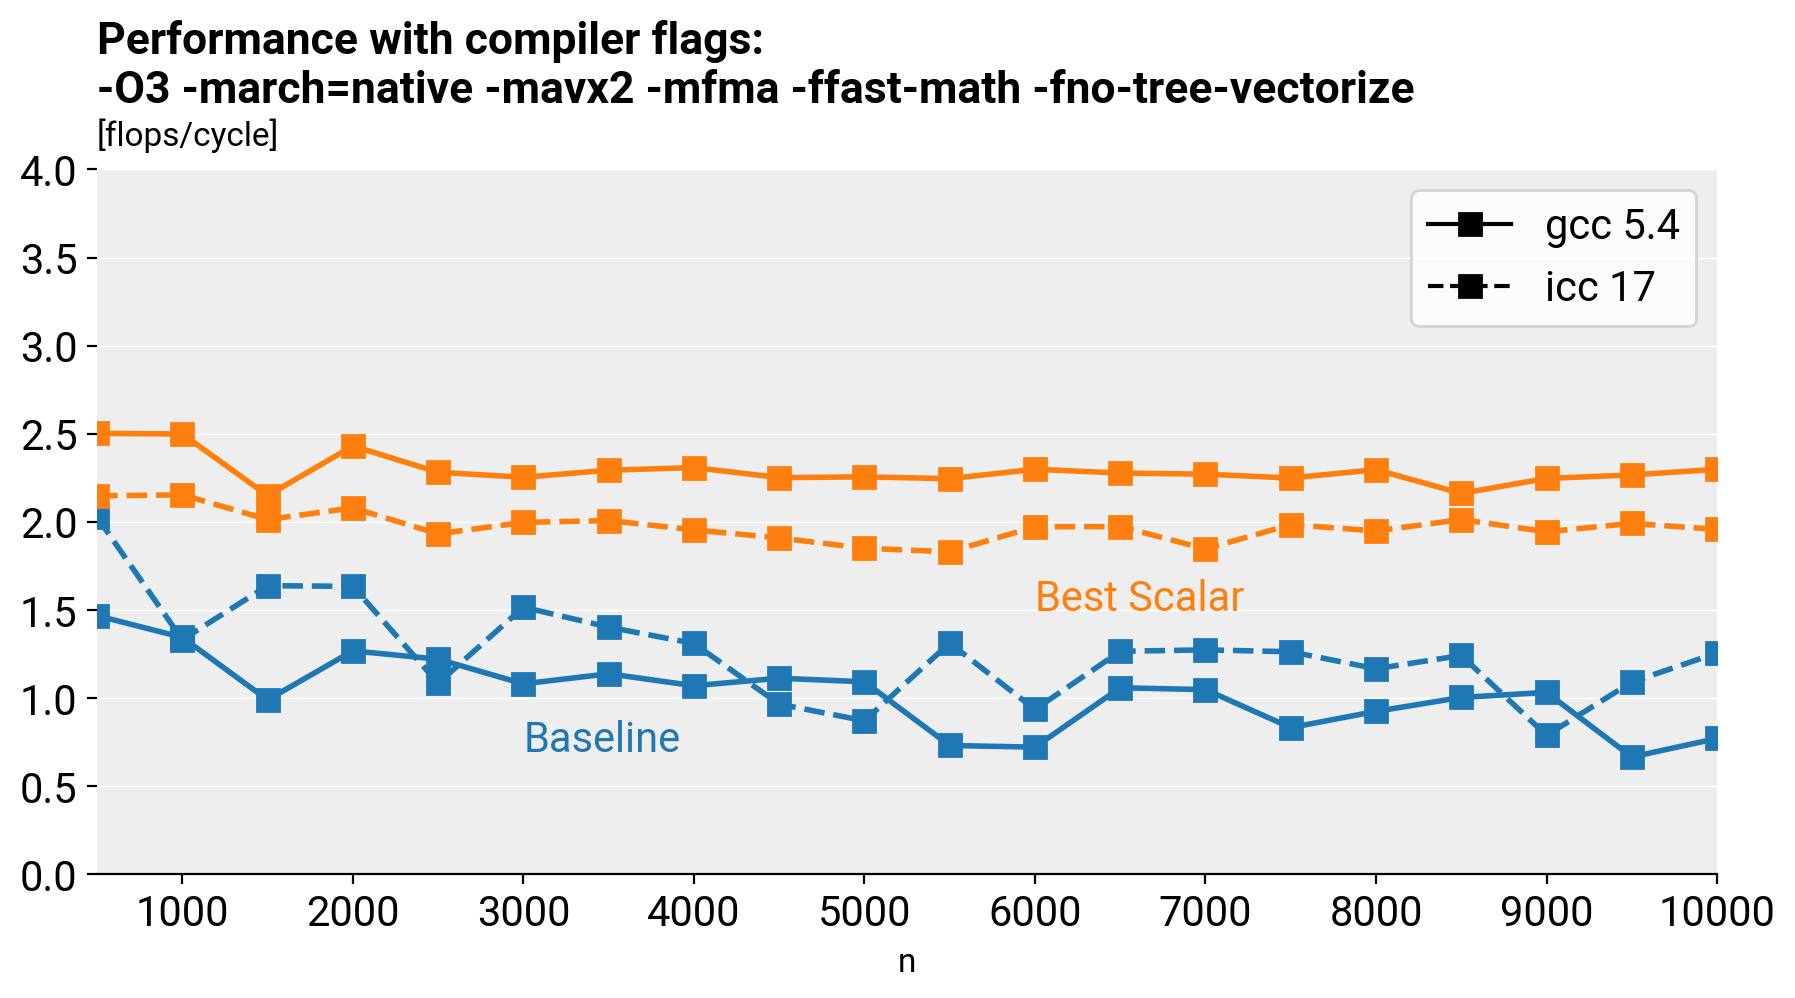

In [107]:
mpl.rcParams['figure.figsize'] = (8.1, 5)
title = "Performance with compiler flags: \n-O3 -march=native -mavx2 -mfma -ffast-math -fno-tree-vectorize"
ylabel = "flops/cycle"
legend = True
lw = 2
marker = "s"
markersize = 8
labels_fontsize = 12
fontsize = 20
xlabel = "n"
ymax = 4

fig = plt.figure()
if title:
    fig.suptitle(title, fontweight='bold', fontsize=16, x=0, ha='left')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=.83, left=0, right=1)

base_gcc, = ax.plot(N, baseline_gcc_novec["perf"][:,-1], 
                linewidth=lw, marker=marker, markersize=markersize, label="Baseline GCC")
base_icc, = ax.plot(N, baseline_icc_novec["perf"][:,-1], c=base_gcc.get_color(), linestyle="dashed",
                linewidth=lw, marker=marker, markersize=markersize, label="Baseline ICC")
scalar_gcc, = ax.plot(N, scalar_gcc_novec["perf"][:,-1], 
                linewidth=lw, marker=marker, markersize=markersize, label="Scalar GCC")
scalar_icc, = ax.plot(N, scalar_icc_novec["perf"][:,-1], c=scalar_gcc.get_color(), linestyle="dashed",
                linewidth=lw, marker=marker, markersize=markersize, label="Scalar ICC")
#avx_gcc, = ax.plot(N, avx_gcc_vec["perf"][:,-1], 
#                linewidth=lw, marker=marker, markersize=markersize, label="AVX GCC")
#avx_icc, = ax.plot(N, avx_icc_vec["perf"][:,-1], c=avx_gcc.get_color(), linestyle="dashed",
#                linewidth=lw, marker=marker, markersize=markersize, label="AVX ICC")
gcc_patch = mlines.Line2D([], [], marker=marker, markersize=markersize, color="k", label="gcc 5.4")
icc_patch = mlines.Line2D([], [], marker=marker, markersize=markersize, color="k", linestyle="dashed", label="icc 17")
ax.legend(handles=[gcc_patch, icc_patch])

ax.text(3000, 0.7, "Baseline", color=base_gcc.get_color())
ax.text(6000, 1.5, "Best Scalar", color=scalar_gcc.get_color())
#ax.text(4000, 3.5, "Best AVX", color=avx_gcc.get_color(), fontweight="bold")

ax.set_xlim([N.min(), N.max()])
ax.set_xlabel(xlabel, fontsize=labels_fontsize)
ax.set_ylim([0, ymax])

# For runtime plots where on the yaxis there is an exponent, place the text
# on the axis title
exponent_text = ''
ax.ticklabel_format(axis='y', style='sci')
plt.draw()
if ax.yaxis.get_offset_text().get_text() != '':
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    exponent_text = '[{}]'.format(ax.yaxis.get_offset_text().get_text())
    ax.yaxis.offsetText.set_visible(False)

ax.set_title(
    '[{}]{}'.format(ylabel, exponent_text),
    fontsize=labels_fontsize,
    position=(0, 1.0),
    ha='left',
    va='bottom')

ax.yaxis.grid(color='#ffffff', linestyle='-', linewidth=.5)
ax.set_facecolor('#eeeeee')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.set_xticks(np.arange(1000, 10000+1, 1000))
ax.set_xticklabels(np.arange(1000, 10000+1, 1000))

plt.show()

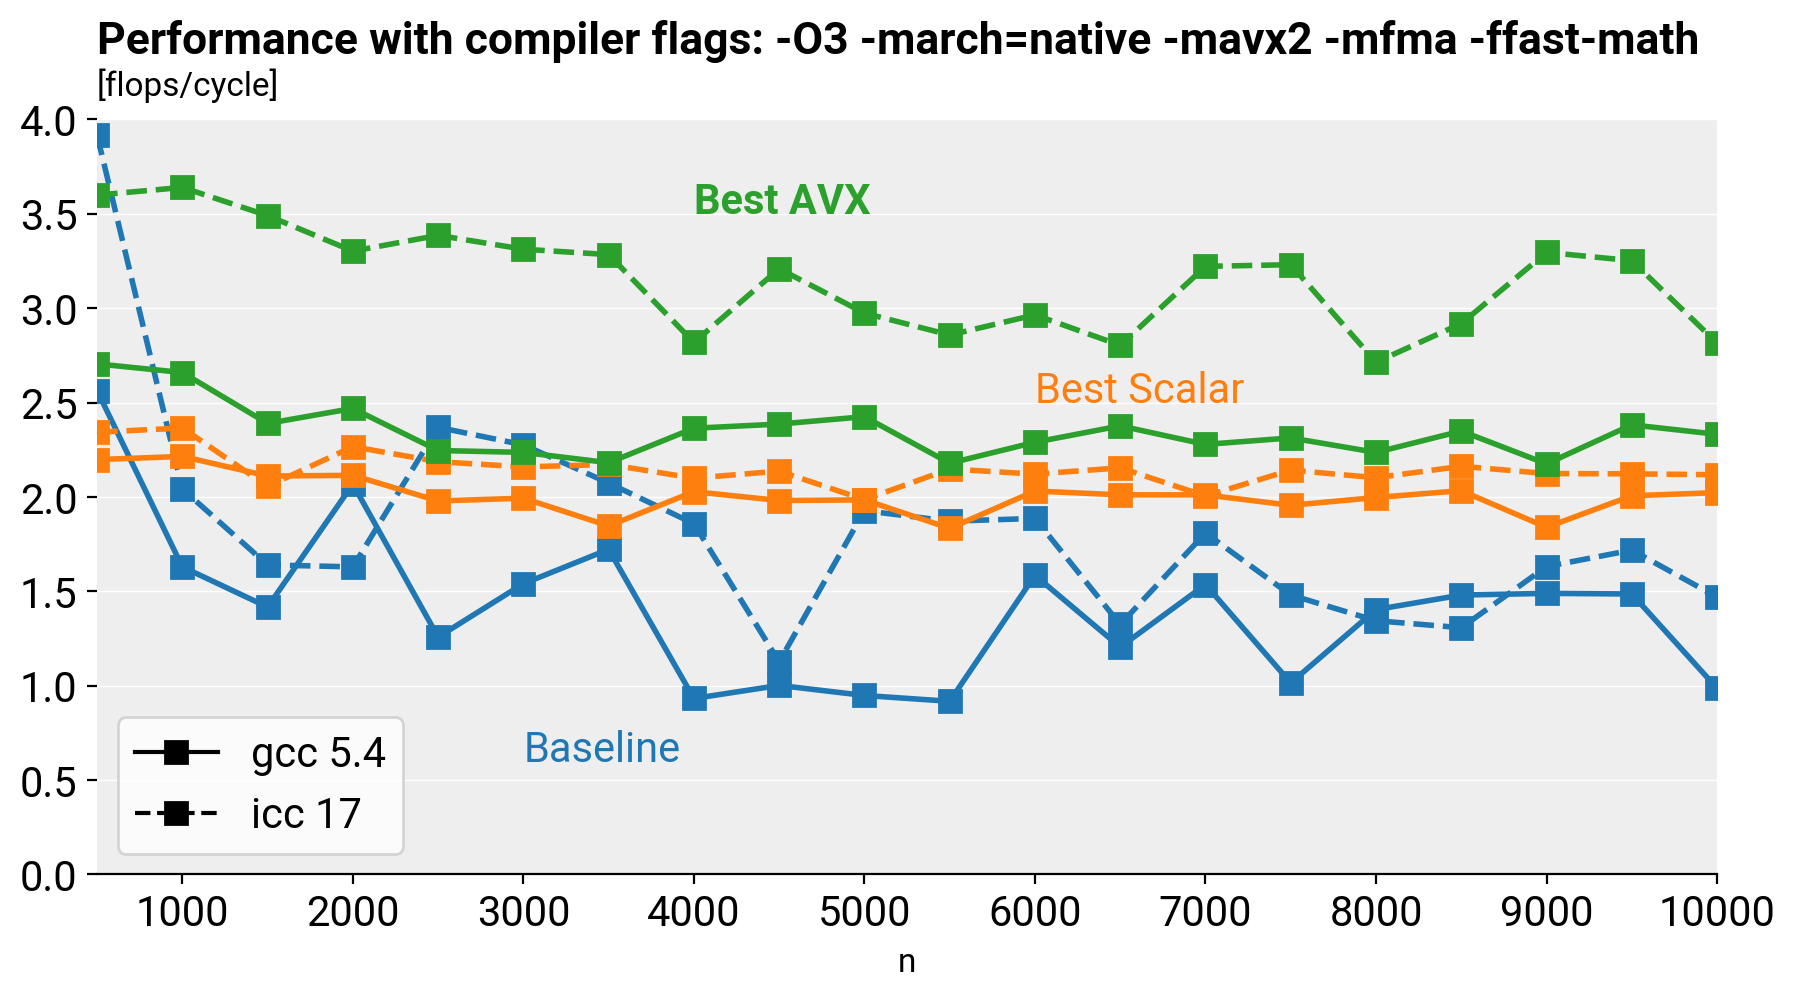

In [88]:
mpl.rcParams['figure.figsize'] = (8.1, 5)
title = r"Performance with compiler flags: -O3 -march=native -mavx2 -mfma -ffast-math"
ylabel = "flops/cycle"
legend = True
lw = 2
marker = "s"
markersize = 8
labels_fontsize = 12
fontsize = 20
xlabel = "n"
ymax = 4

fig = plt.figure()
if title:
    fig.suptitle(title, fontweight='bold', fontsize=16, x=0, ha='left')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=.88, left=0, right=1)

base_gcc, = ax.plot(N, baseline_gcc_vec["perf"][:,-1], 
                linewidth=lw, marker=marker, markersize=markersize, label="Baseline GCC")
base_icc, = ax.plot(N, baseline_icc_vec["perf"][:,-1], c=base_gcc.get_color(), linestyle="dashed",
                linewidth=lw, marker=marker, markersize=markersize, label="Baseline ICC")
scalar_gcc, = ax.plot(N, scalar_gcc_vec["perf"][:,-1], 
                linewidth=lw, marker=marker, markersize=markersize, label="Scalar GCC")
scalar_icc, = ax.plot(N, scalar_icc_vec["perf"][:,-1], c=scalar_gcc.get_color(), linestyle="dashed",
                linewidth=lw, marker=marker, markersize=markersize, label="Scalar ICC")
avx_gcc, = ax.plot(N, avx_gcc_vec["perf"][:,-1], 
                linewidth=lw, marker=marker, markersize=markersize, label="AVX GCC")
avx_icc, = ax.plot(N, avx_icc_vec["perf"][:,-1], c=avx_gcc.get_color(), linestyle="dashed",
                linewidth=lw, marker=marker, markersize=markersize, label="AVX ICC")
gcc_patch = mlines.Line2D([], [], marker=marker, markersize=markersize, color="k", label="gcc 5.4")
icc_patch = mlines.Line2D([], [], marker=marker, markersize=markersize, color="k", linestyle="dashed", label="icc 17")
ax.legend(handles=[gcc_patch, icc_patch])

ax.text(3000, 0.6, "Baseline", color=base_gcc.get_color())
ax.text(6000, 2.5, "Best Scalar", color=scalar_gcc.get_color())
ax.text(4000, 3.5, "Best AVX", color=avx_gcc.get_color(), fontweight="bold")

ax.set_xlim([N.min(), N.max()])
ax.set_xlabel(xlabel, fontsize=labels_fontsize)
ax.set_ylim([0, ymax])

# For runtime plots where on the yaxis there is an exponent, place the text
# on the axis title
exponent_text = ''
ax.ticklabel_format(axis='y', style='sci')
plt.draw()
if ax.yaxis.get_offset_text().get_text() != '':
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    exponent_text = '[{}]'.format(ax.yaxis.get_offset_text().get_text())
    ax.yaxis.offsetText.set_visible(False)

ax.set_title(
    '[{}]{}'.format(ylabel, exponent_text),
    fontsize=labels_fontsize,
    position=(0, 1.0),
    ha='left',
    va='bottom')

ax.yaxis.grid(color='#ffffff', linestyle='-', linewidth=.5)
ax.set_facecolor('#eeeeee')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.set_xticks(np.arange(1000, 10000+1, 1000))
ax.set_xticklabels(np.arange(1000, 10000+1, 1000))

plt.show()

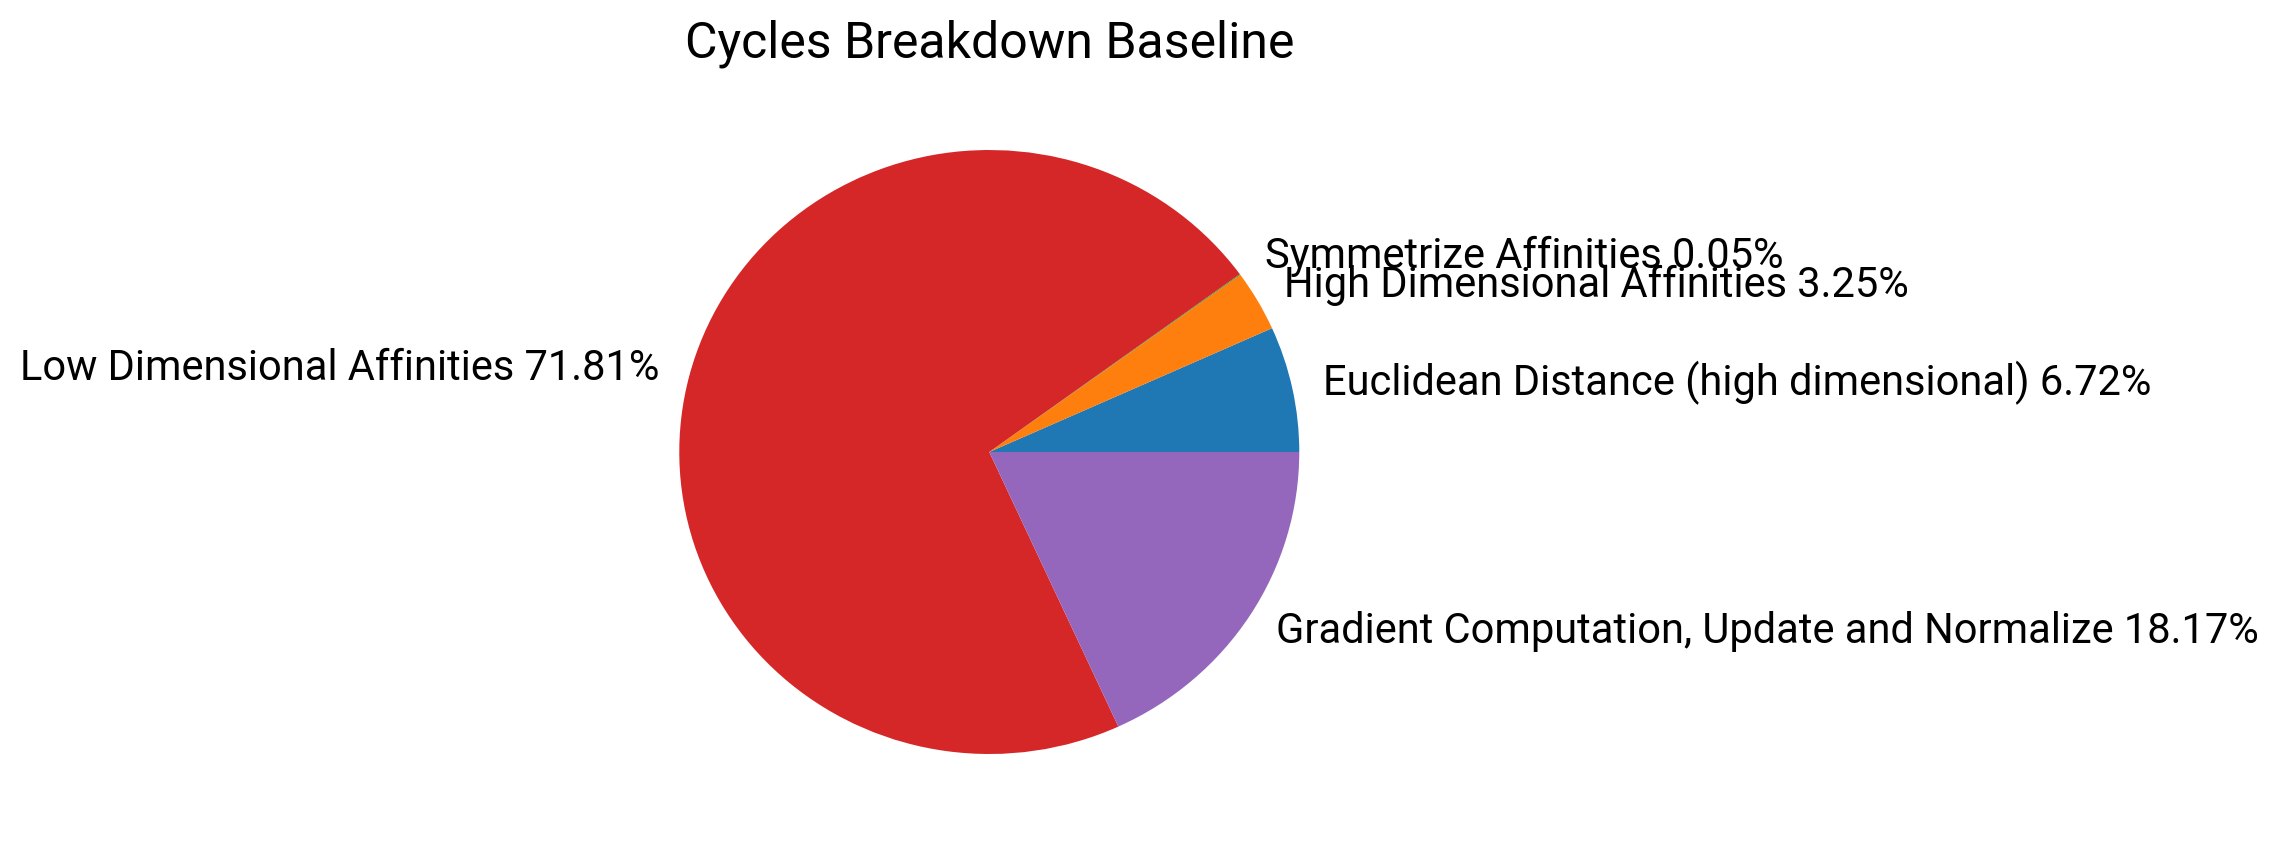

In [120]:
functions_list = [
    "Euclidean Distance (high dimensional)",
    "High Dimensional Affinities",
    "Symmetrize Affinities",
    "Low Dimensional Affinities",
    "Gradient Computation, Update and Normalize"
]

# Compiler gcc and novec for baseline and scalar
disp_names = list(functions_list)
cycles_mean_baseline = baseline_gcc_novec["cycles"].mean(axis=0)
split = cycles_mean_baseline[:-1] / cycles_mean_baseline[-1]
for i in range(len(split)):
    disp_names[i] = disp_names[i] + " " + "%.2f"%(100*split[i]) + "%"

mpl.rcParams['figure.figsize'] = (5, 5)
_, t = plt.pie(split, labels = disp_names)
plt.title("Cycles Breakdown Baseline")

plt.show()

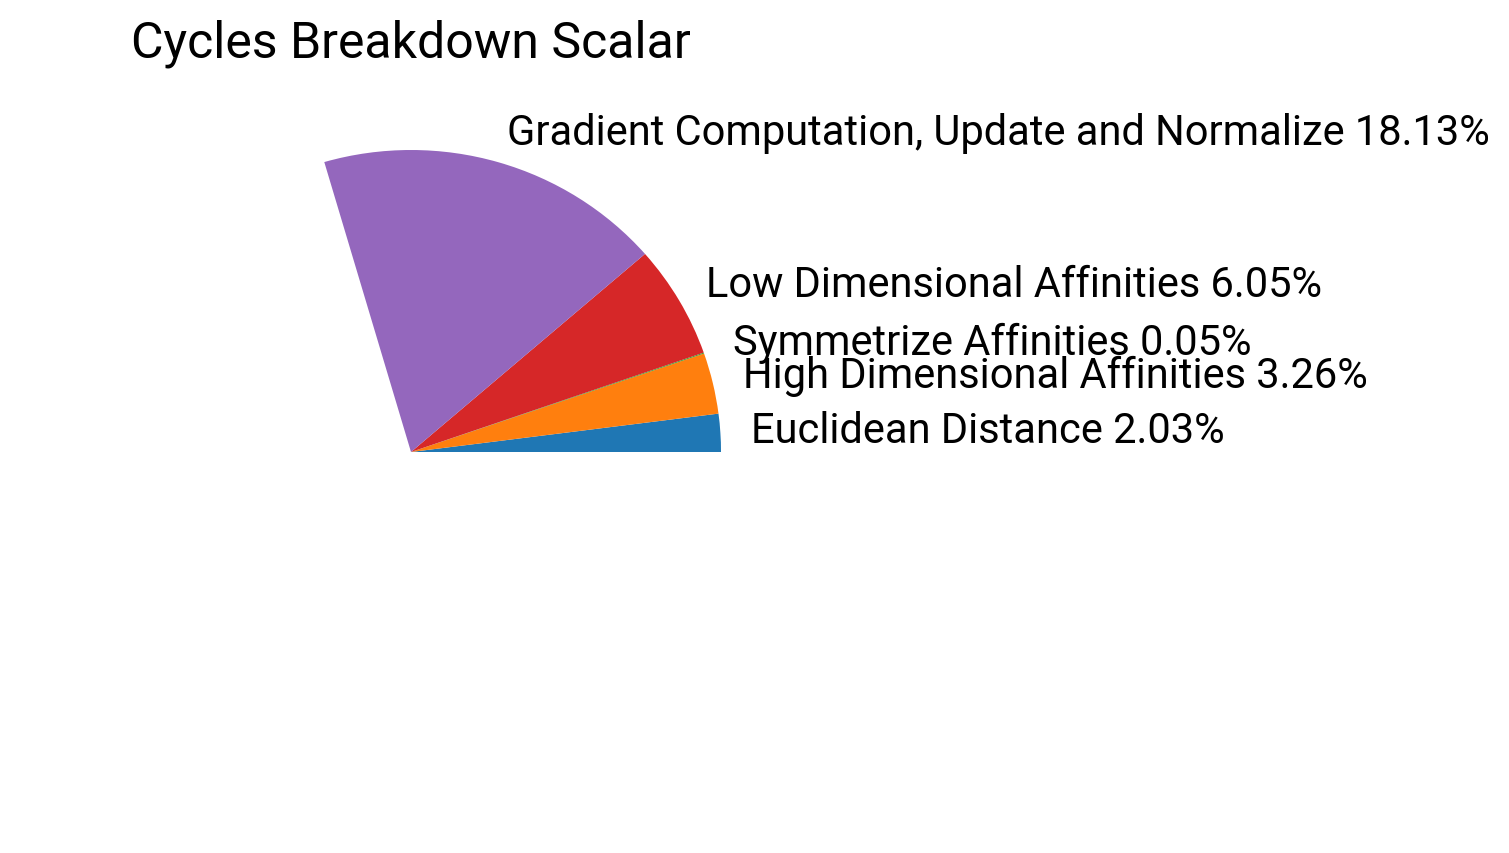

In [128]:
functions_list = [
    #"Difference",
    "Euclidean Distance",
    "High Dimensional Affinities",
    "Symmetrize Affinities",
    "Low Dimensional Affinities",
    "Gradient Computation, Update and Normalize"
]

# Compiler gcc and novec for baseline and scalar
disp_names = list(functions_list)
cycles_mean_scalar = scalar_gcc_novec["cycles"].mean(axis=0)
split = cycles_mean_scalar[:-1] / cycles_mean_baseline[-1]
for i in range(len(split)):
    disp_names[i] = disp_names[i] + " " + "%.2f"%(100*split[i]) + "%"

mpl.rcParams['figure.figsize'] = (5, 5)
_, t = plt.pie(split, labels = disp_names)
plt.title("Cycles Breakdown Scalar")

plt.show()

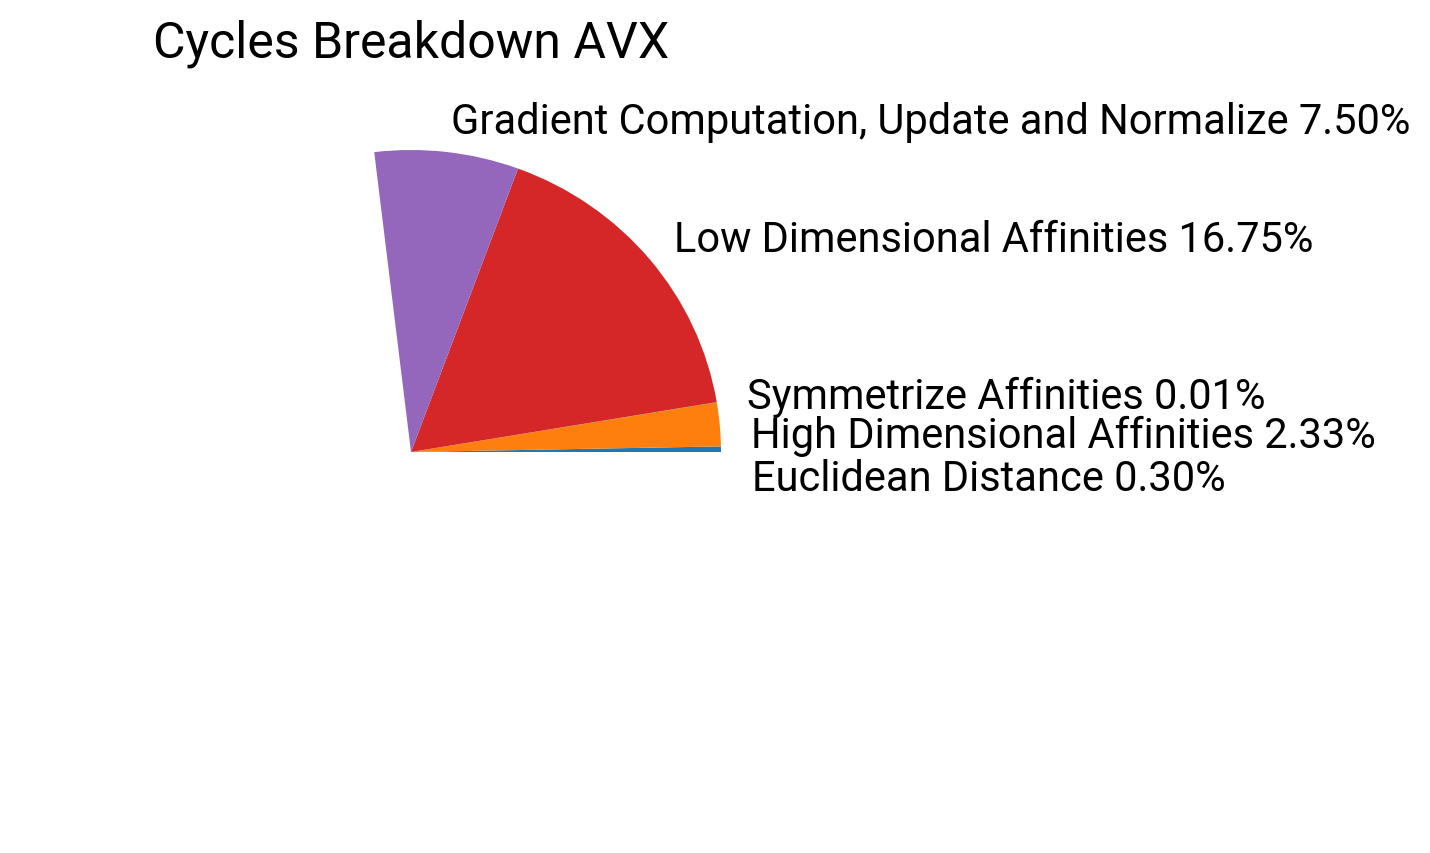

In [135]:
functions_list = [
    #"Difference",
    "Euclidean Distance",
    "High Dimensional Affinities",
    "Symmetrize Affinities",
    "Low Dimensional Affinities",
    "Gradient Computation, Update and Normalize"
]

# Compiler gcc and novec for baseline and scalar
disp_names = list(functions_list)
cycles_mean_avx = avx_gcc_vec["cycles"].mean(axis=0)
split = cycles_mean_avx[:-1] / cycles_mean_baseline[-1]
for i in range(len(split)):
    disp_names[i] = disp_names[i] + " " + "%.2f"%(100*split[i]) + "%"

mpl.rcParams['figure.figsize'] = (5, 5)
_, t = plt.pie(split, labels = disp_names)
(x, y) = t[0].get_position()
t[0].set_position((x, y-.1))
(x, y) = t[1].get_position()
t[1].set_position((x, y-.05))
plt.title("Cycles Breakdown AVX")

plt.show()